In [1]:
import IPython.display as ipd

#core
import numpy as np
import matplotlib.pyplot as plt

#CSV / DF Preparation
import pandas as pd
from scipy.io import wavfile
from tqdm import tqdm
from os import remove


#training
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

#audio analysis functions:
import Seth_Adams_Functions as saf


#audio processing functions:
import librosa
from python_speech_features import mfcc,logfbank

#other
import pickle
from os.path import isfile


<h4>46558098 Portfolio Part 4 </h4>
<h3>Training a Classification Model to identify the correct type of drum sound in a sample</h3>

The purpose of this analysis is to understand wether the audible features of a specific type of drum sound are distinct enough to break into classes that can be used to train a model that can classify unseen drum sounds correctly.

If so, to what extent can we clasify these drum sounds? For example, at the highest level we might have kick, snare, percussion as 3 categories, but these categories can be further broken down, for example percussion can become hat, ride, crash, etc.

Though the scope of this portfolio is not deep enough to explore the building of custom predictive models from scratch, we will attempt to maximise the performance of our model by exploring a variety of methods and testing various hyperparameters.

Essentially, the importance of this topic lies in the lack of standard naming conventions for sound samples. To be able to quickly classify instruments according to certain classes can allow musicians to efficiently organise massive sample libraries without missing mis-labelled or un-labelled samples. Ultimately, we would aim to develop a model that can perform with high accuracy that allows us to classify an input drum sound correctly.

Unfortunately, with audio data the nature of how to approach the problem is not so intuitive. Hopefully without diving too deeply into the music topics, let's begin to lay out the process we aim to use to answer our questions, as well as describing the data sources. There will likely be alot of terminology that will escape the non-musical reader, but if the background information can be understood at a basic level then with the assistance of visualisations and explanations most readers should not struggle to follow. 

<h3>Data Source</h3>
The data source we will be using has been developed by myself from a very large base of audio samples. Many, but not all audio samples are labelled according to the type of sound, to help producers search for them. For example, a hat sound will have the word "hat" in the filename most of the time, and a closed hat / open hat would have strings like "closed, chh, ch" / "open, ohh, oh" alongside the word "hat".
These filenames have been parsed and the location to the file has been stored in a dataframe alongside the classification of the sound based on name alone. 

<h3>Process</h3>
The steps we will undertake in this project include analysing sounds class by class, identifying the features that predominantly define a type of sound and then evaluating which type of model is best suited for predicting unlabelled data based on these features.


In [2]:
#DF Preparation

df = pd.read_csv("./dataset/labelled_filenames.csv")
df.set_index("path", inplace=True)
original_length = len(df)

#Not all paths are available in the dataset, and some are incompatible with the wavfile.read function, so we will have to do some data cleaning to ensure that we can read all of the files.
for f in df.index:
    try:
        rate,signal = wavfile.read(f)
        df.at[f,"length"] = signal.shape[0]/rate
        df.at[f,"rate"] = rate
    except:
        df.drop(index=f, inplace=True)

print(f"removed {original_length - len(df)} out of {original_length} files from df")


removed 446 out of 9414 files from df


In [3]:
#To avoid re-making the CSV, run any data exploration code here.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8968 entries, ./samples/ELX_BTD_kick_mid_sauce.wav to ./samples/fsh2_hat_one_shot_open_crunch_oldskool.wav
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   8968 non-null   object 
 1   length  8968 non-null   float64
 2   rate    8968 non-null   float64
dtypes: float64(2), object(1)
memory usage: 538.3+ KB


Now we have a dataframe with the length and sample rate of each file located at some path, which will allow us to read more specific information from the sound further along the line. For now, lets visualise our dataset to better understand it.

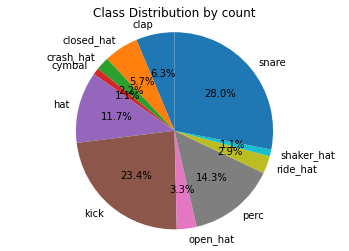

In [4]:
#Visualisation
def visualise_class_distribution(df):
    classes = list(np.unique(df.label)) #Get a list of the unique labels in the dataset
    class_dist_count = df.groupby(['label']).size() #Get the number of files in each class

    fig,ax = plt.subplots(nrows=1,ncols=1)

    ax.set_title('Class Distribution by count')
    ax.pie(class_dist_count, labels=class_dist_count.index, autopct='%1.1f%%',
    shadow = False, startangle=90)
    ax.axis('equal')

visualise_class_distribution(df)

Given that the disproportionate representation of some categories will likely affect our model performance, we will apply some filters to group sub-categories into a single parent category. We should aim to have an equal representation of classes else we invite the possibility of including/excluding too much or too little of one category from test data, which can affect model performance.

First of all, we will apply the 'hat' label to anything that is a hat. The distinction between hat types is useful, but as you can see they are much smaller than the other categories.

Additionally, we will remove the "perc" label, as perc is a general term used to describe any percussive element. Samples under this classification vary wildly, and can even belong to other classes so there exists the possibility that it will confuse the model.

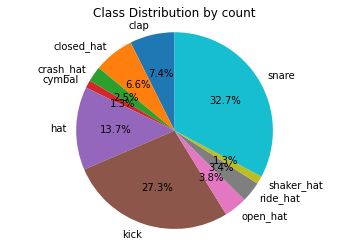

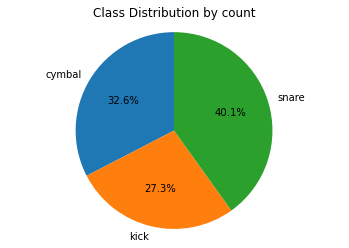

In [5]:
df = df[df.label != "perc"]
visualise_class_distribution(df)

df_simple = df.copy(deep=True)
for index,row in df_simple.iterrows():
    if "hat" in str(row.label):
        df_simple.at[index,"label"] = "cymbal"
    elif "clap" in str(row.label):
        df_simple.at[index,"label"] = "snare"

visualise_class_distribution(df_simple)


df.reset_index(inplace=True)
df_simple.reset_index(inplace=True)


As you can see now, our samples are alot more balanced. Clap is disproportionately represented, and we will merge with snare if any issues arise.<br>

<i>Update: We have merged snare with clap, to ensure that we were not getting classification errors due to the low proportion of claps and/or the more likely case of misclassification of claps as snares and vice versa as they both share a similar space in the mix. 

<br>
Update 2: Even though snare and clap were merged, there was no major performance improvement suggesting that this is not an issue. Still, we have let them remain grouped for consistencies sake.
</i>

Now that we have described the dataset somewhat, lets delve into what these categories of audio actually look like.


As percievable audio increases logarimhthmically (ie; 1 octave above 30hz is 60hz, where 1 octave above 4000hz is 8000hz), we will need to introduce a few tools to account for this when we handle our data: The first of which is known as the Mel-frequency filterbanks. Representing our sounds in terms of mels filters, rather than frequency, will allow our model to interpret changes in frequency in a more human manner as it transforms the logarithmic frequency spectrum into a linear set of filters, or 'Mels'.

In [6]:
#Define some constants to use throughout the notebook
N_FILT = 26 #Number of filters to use in our mel filterbank

In our next cell, we will be collecting information and using it to visualise our dataset. This will help the reader to understand the subtle differences in the class of sound we are talking about

dict_keys(['clap', 'closed_hat', 'crash_hat', 'cymbal', 'hat', 'kick', 'open_hat', 'ride_hat', 'shaker_hat', 'snare'])


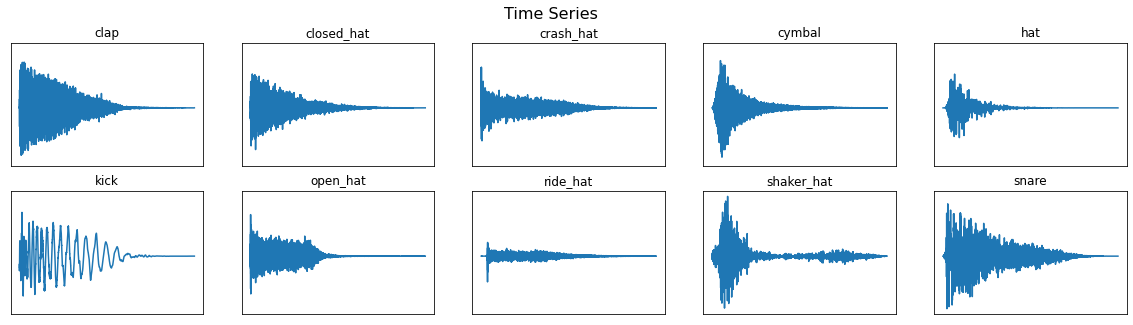

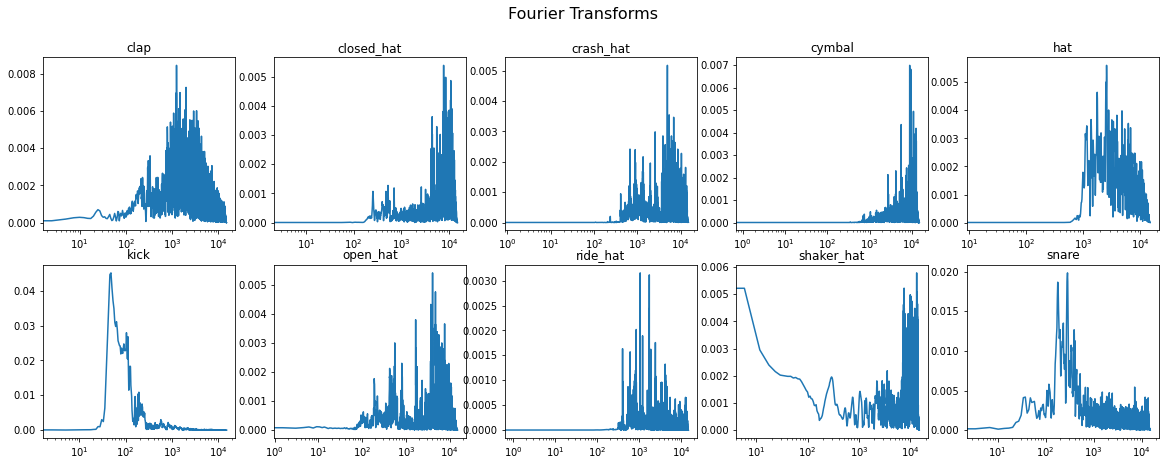

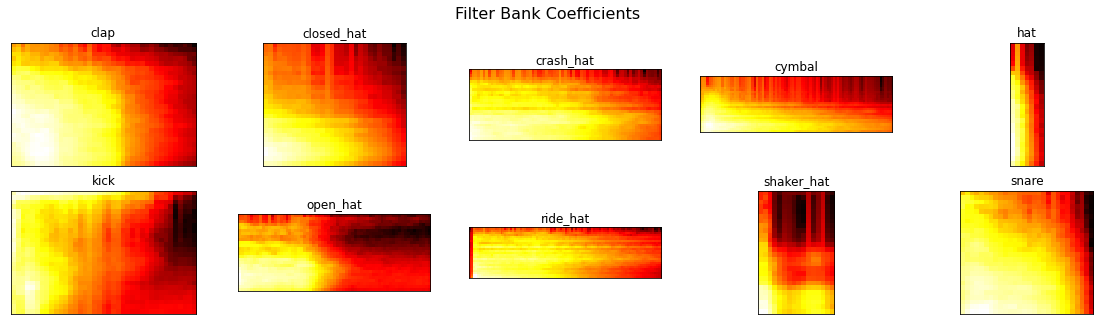

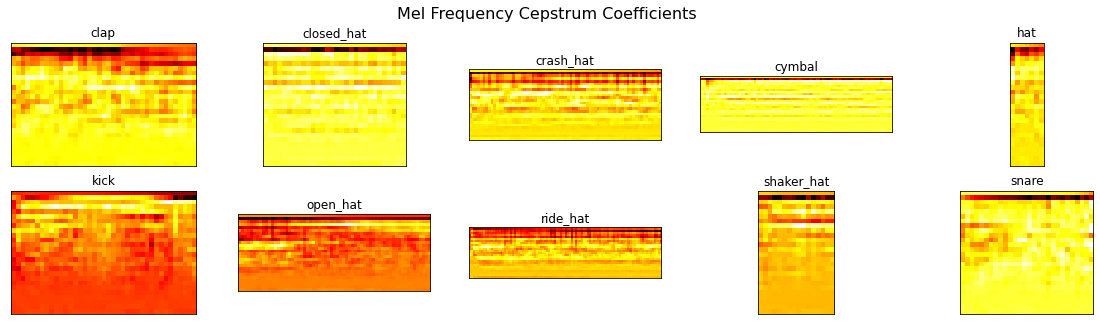

In [7]:
signals = {} #Data structure to hold our audio signals, which are stored as a numpy array
fft = {} #Data structure to hold our fast fourier transforms, which are stored as a numpy array
fbank = {} #Data structure to hold our filterbanks, which are stored as a numpy array
mfccs = {} #Data structure to hold our mel frequency cepstral coefficients, which are stored as a numpy array


audiofns = saf.Functions()
print(audiofns)

if True == True:
    for category in np.unique(df.label):
        wav_file = df[df.label == category].iloc[0]
        signal, rate = librosa.load(wav_file['path'], sr=wav_file['rate'])
        rate = int(rate)
        mask = audiofns.envelope(signal, rate, 0.0005)
        signal = signal[mask]
        signals[category] = signal
        fft[category] = audiofns.calc_fft(signal, rate)

        bank = logfbank(signal[:rate], rate, nfilt=N_FILT, nfft=rate+1//40).T #nfft should be = to window length when doing short fft
        fbank[category] = bank
        mel = mfcc(signal[:rate],rate, numcep=N_FILT+1//2, nfilt=N_FILT, nfft=rate+1//40).T#numsep is the number of ceptrals we keep after doing discrete cosine transform. typically we throw away half of redundant freqs
        mfccs[category] = mel


print(signals.keys())
audiofns.plot_signals(signals)
plt.show()
audiofns.plot_fft(fft)
plt.show()
audiofns.plot_fbank(fbank)
plt.show()
audiofns.plot_mfccs(mfccs)
plt.show()

From the above visualisations, we can observe the subtle differences between instrument classes. For example, take notice of the varied length of each visualisation in the Mel Frequency Cepstrum Coefficients figure. Both the frequency spectrum over time, and the length of the time can be used to differenciate these sample types. Of course, since we only have the audio signal, it can become difficult to seperate these features in a way that can be passed into a model effectively. This is because we need to assign multiple sets of multi-dimensional, variable length time series information to a specific signal as features, and then use a model to analyse this. There are a few approaches to take to achieve this, however the most intuitive method seems to be to use a model that is able to extract features and learn from complex data, such as a neural network.

Just to further explore the data a little and set some hypothesis around why a neural network would be able to successfully classify sounds in the first place, lets analyse one of the "features" that we as humans can easily identify and ideally a neural network would learn to identify as well.

An important feature we will visualise is the transient of the sound. The transient of a sound is the short burst, click, pop or sound that we hear when a drum plays through the speakers. They can be thought of as the "head" of a drum beat, and the sound that occurs as the sound decays to silence is the tail. Different classes of drums have similar types of transients, as they have a distinct sound that classes these drums together. We will visualise some of these transients below:

First, lets visualise a kick and see if we can identify the transient from the graph visually

(11863,)
[-2.3824286e-01 -2.8469160e-01 -2.3992571e-01 ...  1.8383967e-04
  1.8488400e-04  2.1495555e-04]


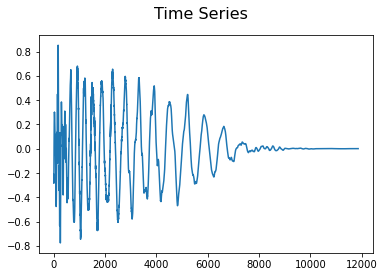

(array([7.31670932e-10, 6.62046765e-05, 3.37408357e-05, ...,
       1.16861748e-06, 1.19867295e-06, 1.22100306e-06]), array([0.00000000e+00, 2.52887128e+00, 5.05774256e+00, ...,
       1.49936778e+04, 1.49962067e+04, 1.49987356e+04]))
(26, 39)
(26, 39)


In [8]:
df_kicks = df[df.label == "kick"]
df_kicks.reset_index(inplace=True)
one_kick = df_kicks.loc[0]
signal, rate = librosa.load(one_kick['path'], sr=one_kick['rate'])
rate = int(rate)
mask = audiofns.envelope(signal, rate, 0.0005)
signal = signal[mask]
fft = audiofns.calc_fft(signal, rate)
fbank = logfbank(signal[:rate], rate, nfilt=N_FILT, nfft=rate+1//40).T #nfft should be = to window length when doing short fft
mfccs = mfcc(signal[:rate],rate, numcep=N_FILT+1//2, nfilt=N_FILT, nfft=rate+1//40).T#numsep is the number of ceptrals we keep after doing discrete cosine transform. typically we throw away half of redundant freqs


#print(one_kick)
print(signal.shape)
print(signal)
audiofns.plot_signal(signal)
plt.show()
print(fft)
print(fbank.shape)
print(mfccs.shape)


As we can see, the portion from the loudest part of the sound is the transient. It is a higher frequency than the rest of the sound, and reflects an impact on the membrane before the vibration of the drum membrane rings out to give the sound the rest of its body.

Lets look at this transient closer up:

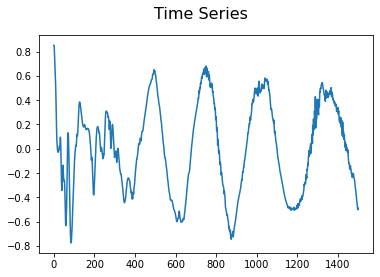

In [9]:
def max_loc_transient(signal, rate=30000):
#first, find the location of the maximum signal
    max_loc = np.argmax(signal)
    #calculate the transient length, in samples
    transient_length = int(0.05 * rate)
    transient = signal[max_loc:max_loc+transient_length]
    
    return transient

#using our kick
audiofns.plot_signal(max_loc_transient(signal))


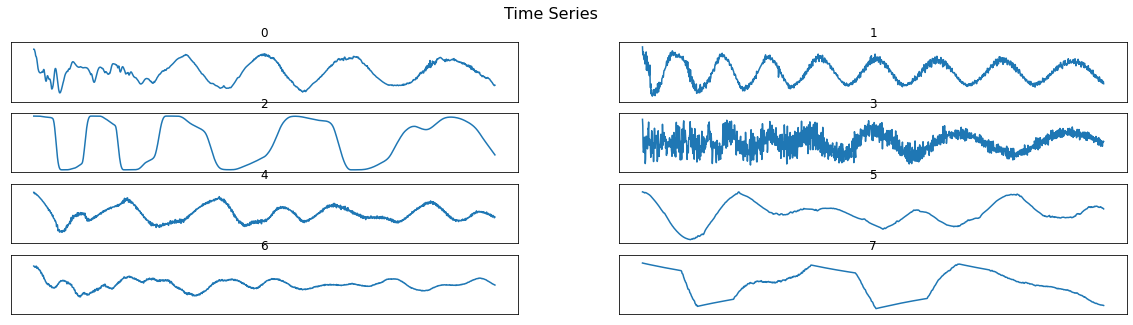

In [10]:
#As we can see, the transient is a very short but loud part of the signal that is higher frequency to the rest of the kick.
#Lets try plotting the transients of a selection of kicks on top of eachother and see if we can identify any similarities

def get_n_signals(df, category, n=5):
    signals = []
    for i in range(n):
        temp = df[df.label == category]
        temp.reset_index(inplace=True)
        signal, rate = librosa.load(temp.loc[i]['path'], sr=temp.loc[i]['rate'])
        rate = int(rate)
        mask = audiofns.envelope(signal, rate, 0.01)
        signal = signal[mask]
        signals.append(signal)
    return signals

signals = get_n_signals(df, "kick", n=8)
transients = {}
for i in range(len(signals)):
    transients[i] = max_loc_transient(signals[i])
audiofns.plot_signals(transients,nrows=4)



As we can observe from the graphs, kick transients begin higher frequency than the body of the sound, and decay quickly into lower frequncies. - however, there is not a massive difference in the volume throughout the transient. Lets compare this to some transients from another class of instrument, a snare:

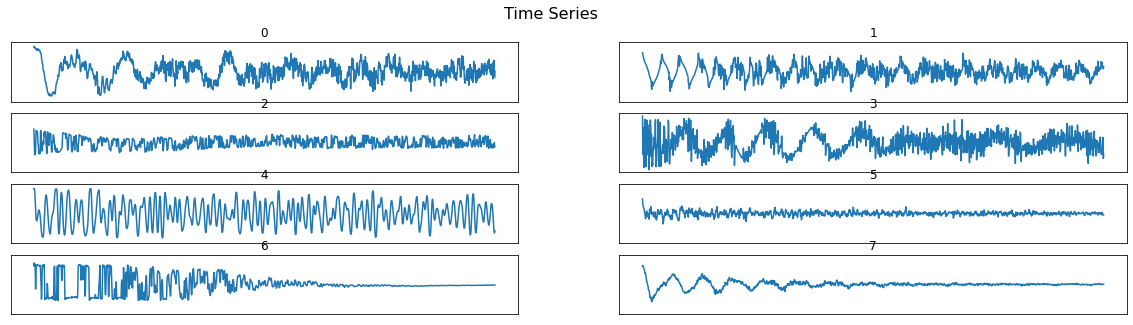

In [11]:
signals = get_n_signals(df, "snare", n=8)
transients_snare = {}
for i in range(len(signals)):
    transients_snare[i] = max_loc_transient(signals[i])
audiofns.plot_signals(transients_snare,nrows=4)

Here we see an interesting pattern emerge: The transient content of the snare often begins with lower frequency content, before decaying into higher frequency content. This makes sense for a few reasons: The membrane of a snare drum is very tight compared to the kick drum. This means the frequencies present will be lower at the time of impact, but as energy is lost by the tension of the membrane there will be less force driving oscillation and the sound will gradually increase in frequency. Additionally, due to mixing requirements in multi-track audio, snare samples are more likely to be mixed such that they deliver a desireable sound to customers. The analysis of these transients in the context of professionally recorded sounds intended for use in an audio mix makes sense as kicks require some high end to help produce "punch" whereas snares require a boxier, low-mid to produce "body" - Since the kick and snare work together, but sit in different frequency ranges, their transients frequency content seems to reach toward eachother, in order to produce the "beat".

Now that we have some information about our transients, it seems that the Frequencies present in the sound are a key part of classification. lets begin to investigate FFT graphs of kick, snare and hat - our three main drum classifications.

[-0.01419026 -0.01297309 -0.04263085 ... -0.18185332 -0.1732473
  0.        ]


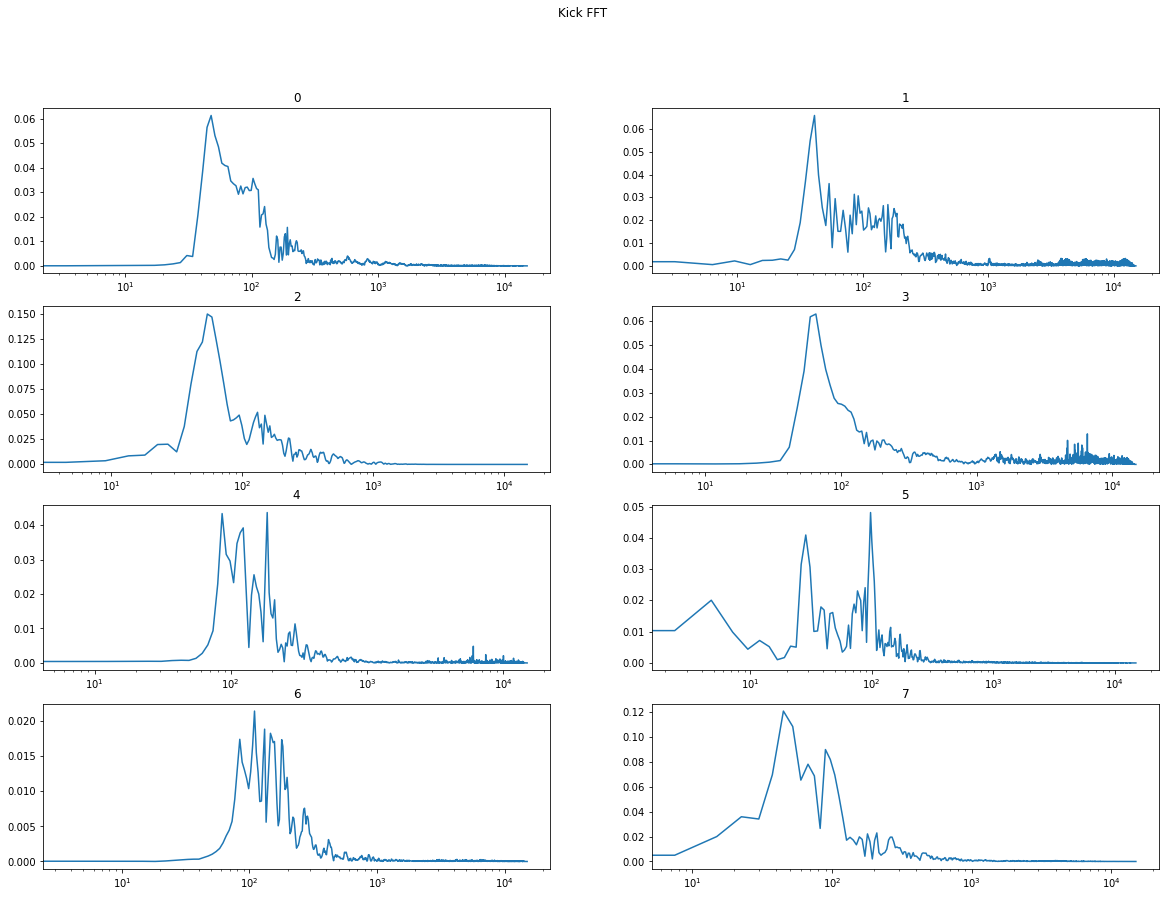

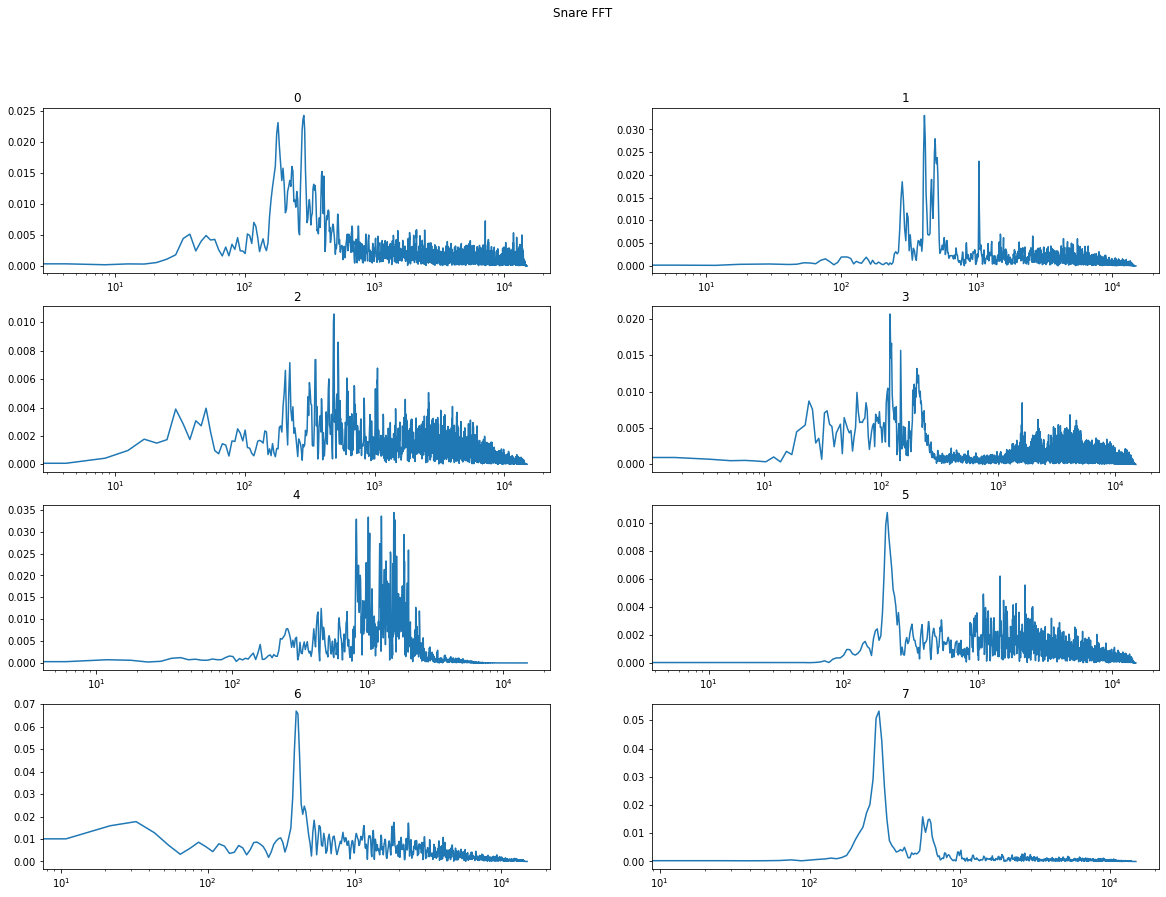

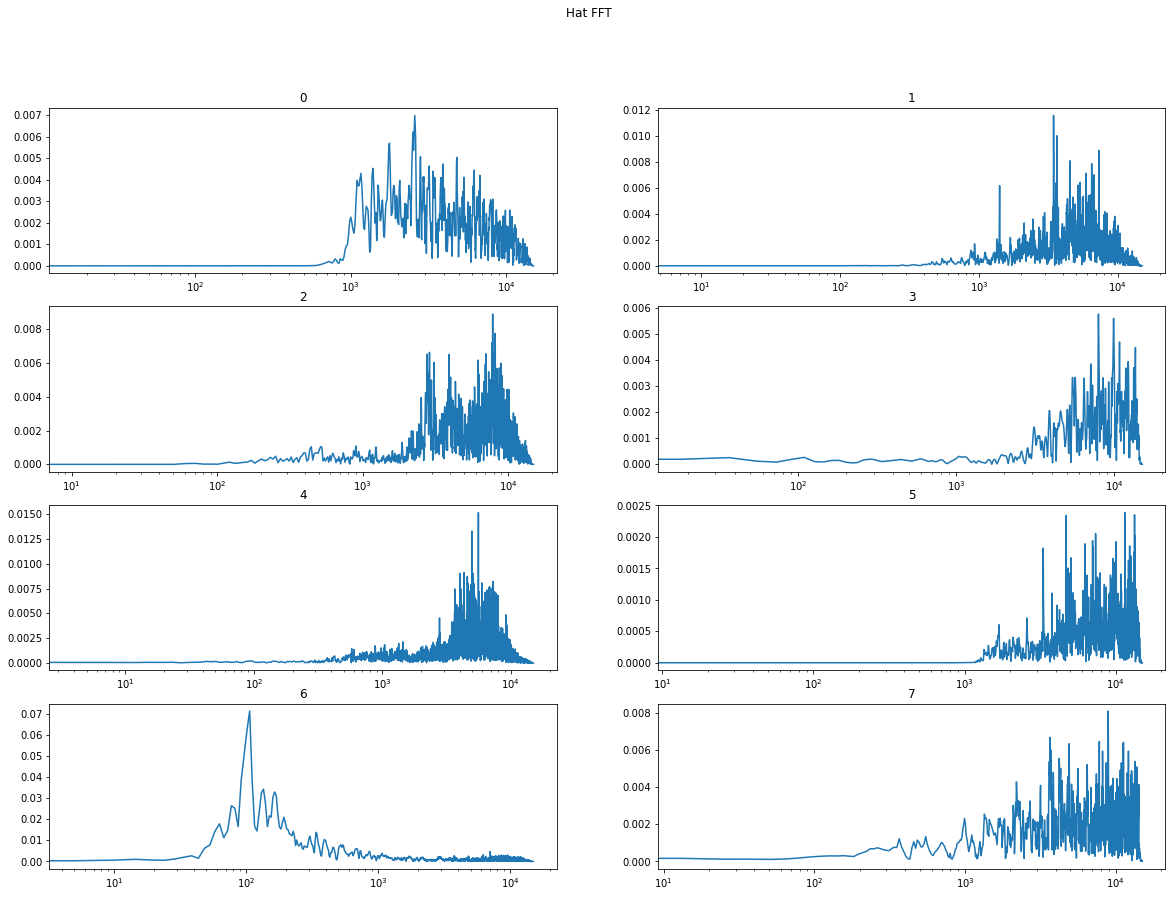

In [12]:
kick_signals = get_n_signals(df, "kick", n=8)
snare_signals = get_n_signals(df, "snare", n=8)
hat_signals = get_n_signals(df, "hat", n=8)




fft_snare = {}
fft_kick = {}
fft_hat = {}

print(kick_signals[1])

for i in range(len(kick_signals)):
    fft_kick[i] = audiofns.calc_fft(kick_signals[i], 30000)
    fft_snare[i] = audiofns.calc_fft(snare_signals[i], 30000)
    fft_hat[i] = audiofns.calc_fft(hat_signals[i], 30000)



audiofns.plot_fft(fft_kick,nrows=4)
plt.suptitle("Kick FFT")
plt.show()

audiofns.plot_fft(fft_snare,nrows=4)
plt.suptitle("Snare FFT")
plt.show()

audiofns.plot_fft(fft_hat,nrows=4)
plt.suptitle("Hat FFT")
plt.show()



As we can see, the sounds in each class have some very distinctive features when displayed using FFT analysis. Some observations include:
- Kick: Frequency content mainly resides in the 30hz-120hz and tapers off approaching 1000hz. Very little high end content compared to other classes
- Snare: Frequency content mainly resides in the 300hz-1000hz range and tapers off approaching 10khz. There is significantly more high end requency content than a kick, and much less low end in terms of magnitude.
- Hat: Very little content below 1khz, with large amounts of content approaching 10khz

Because of these clear distinctions, it seems that the FFT could be a good candidate to feed to our prediction model. However, as we have visualised our results on a logarithmic scale, we require some way of interpreting the data in a similar way. This is where we can use our Mel filterbank functions.

<h1>Feature Building </h1>
As we have many variable length signals, in order to keep our data simple we should treat each signal in the same way we would treat an image. In this sense, we should select a window of samples (discrete) to consider for each sound. In our case, values ~ 1 second at 30kHz sample rate result in zero padded arrays of 30,000 discrete samples.





In [13]:
df_simple.label = pd.Categorical(df_simple.label)
df_simple['labelCode'] = df_simple.label.cat.codes

GLOBAL_RATE = 30000
STEP = int(GLOBAL_RATE/10) #For the step size of our functions

def build_features(target_df,target_df_name):
    #To avoid re-building features from the dataset, if the dataset has already been processed, we can load the features from a pickle file.
    #To force the re-building of the features, delete the pickle named <target_df_name>Xy.pickle from the ./pickle folder
    if isfile('./pickle/' + target_df_name +'Xy.pickle'):
        with open('./pickle/' + target_df_name +'Xy.pickle', 'rb') as f:
            X, y = pickle.load(f)
            return X, y
    
    X = [] #Input variable
    y = [] #Target variable

    #We will have to normalise later, so lets define a min and max value
    min_val = float("inf")
    max_val = -float("inf")

    for index in target_df.index:
        rate, signal = wavfile.read(target_df.loc[index]['path'])
    
        #We will only use the first second of each audio file
        if signal.shape[0] - GLOBAL_RATE < 0:
            shape = np.shape(signal)
            padded_array = np.zeros((GLOBAL_RATE,))
            padded_array[:shape[0]] = signal
            signal = padded_array
        
        sample = signal[:GLOBAL_RATE] 
        X_sample = mfcc(sample, rate, numcep=13, nfilt=26, nfft=750).T

        min_val = min(np.amin(X_sample), min_val)
        max_val = max(np.amax(X_sample), max_val)
        X.append(X_sample)
        y.append(target_df.loc[index]['label'])
    
    X, y = np.array(X), np.array(y)
    X = (X - min_val) / (max_val - min_val)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = pd.Categorical(y, categories=target_df.label.unique()).codes

    with open("./pickle/" +  target_df_name +"Xy.pickle", "wb") as f:
        pickle.dump((X,y), f, protocol=3)

    return X, y


X, y = build_features(df_simple,"df_simple")
print(y)


X = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))

#class_weight = np.compute_class_weight('balanced', classes=np.unique(y_flat), y=y_flat)
#class_weight = {i : class_weight[i] for i in range(len(class_weight))}



[1 1 1 ... 0 0 0]


<h1>Model Choice</h1>

Of the many types of Neural Networks to choose, Recurrent Neural Networks are especially suited to our problem space as they are effective at processing sequence data. This is because processing drum sounds is highly dependent on the signal change over time, with a massive portion of feature detection relying on time series data in some way. In other types of audio classification, such as instrument classification, this dependence is not so pronounced as most instruments give off unique features that can be identified from a single frame of audio.

Another choice that could work successfully is a Convolutional Neural Network. Because the input for a CNN is tensor, rather than pixel, they are able to learn to identify features in the context of space, which may be useful as the relationship and positioning of frequency content within a sound is important in identifying it. The only reason this may not be necessary is that the dataset we use are one shot drum sounds, and all the features are essentially in the same location (transient at the start, main frequency content decays from high to low).

Unfortunately, the SKLearn framework only includes a simple Multi Layer Perceptron. To avoid issues with dependencies across platforms, we will stick to the simple model and evaluate its performance. In the future, we can compare these results to the other models we have mentioned previously. 


First, lets define our train/test data split. Given our large sample dataset, we can afford to have a decent 80/20 split, which should leave us with around ~1000 samples to test on, which should be plenty.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Next, lets define the MultiLayered Perceptron model for classification

In [15]:
mlpmodel = MLPClassifier()

print(x_train.shape, y_train.shape)

#reshape our x_train and x_test to be 2D
mlpmodel.fit(x_train, y_train)
y_pred = mlpmodel.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)*100
cfn = confusion_matrix(y_test, y_pred, labels=[0,1,2])

print("Accuracy for Neural Network is:",accuracy)
print("Confusion Matrix")
print(cfn)

(6147, 1287) (6147,)
Accuracy for Neural Network is: 90.82628497072218
Confusion Matrix
[[393   6  98]
 [  4 413  13]
 [ 13   7 590]]


So, our accuracy score for the baseline MLPClassifier is around 90%. This is not too bad, but lets see if the tuning of hyperparameters will help improve this result. For consitency across runs, we will use the same train/test split on multiple classifiers of different parameters, and print their statistics

In [16]:
def testmodel(model, x_test, y_test,x_train,y_train, name=""):
    model.fit(x_train, y_train)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)*100
    cfn = confusion_matrix(y_test, y_pred, labels=[0,1,2])

    print("Accuracy for Neural Network \""+name+"\" is:",accuracy)
    print("Confusion Matrix")
    print(cfn)


#lets make a few models
logisticmlp = MLPClassifier(activation='logistic')
tanhmlp = MLPClassifier(activation='tanh')
identitymlp = MLPClassifier(activation='identity')
relumlp = MLPClassifier(activation='relu')

#and test
testmodel(relumlp, x_test, y_test,x_train,y_train, name="relu")
testmodel(logisticmlp, x_test, y_test,x_train,y_train, name="logistic")
testmodel(tanhmlp, x_test, y_test,x_train,y_train, name="tanh")
testmodel(identitymlp, x_test, y_test,x_train,y_train, name="identity")


Accuracy for Neural Network "relu" is: 91.41184124918674
Confusion Matrix
[[463   8  26]
 [ 10 411   9]
 [ 71   8 531]]
Accuracy for Neural Network "logistic" is: 90.24072869225765
Confusion Matrix
[[393   4 100]
 [  7 401  22]
 [ 14   3 593]]
Accuracy for Neural Network "tanh" is: 87.76837996096292
Confusion Matrix
[[472   6  19]
 [ 13 407  10]
 [133   7 470]]
Accuracy for Neural Network "identity" is: 92.38776837996096
Confusion Matrix
[[445  13  39]
 [  2 422   6]
 [ 38  19 553]]


Relu remains the best activation function (In most cases), but there are plenty more hyperparameters to tune. Luckily, we have a nice tool in sklearn that allows us to find the most optimal hyperparameter set, so lets define our parameter space and then run the GridSearchCV() function. 

In [17]:
mlp_gs = MLPClassifier(max_iter=100)

#Removed SGD from solver as it was taking too long to run, and it was not the best performing solver
parameter_space = {
    'hidden_layer_sizes': [(26,), (104,), (26,26) , (104,26)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_train, y_train)

print('Best parameters found:\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

y_true, y_pred = y_test , clf.predict(x_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the 

Using our gridsearch CV through a small, but generally broad search of parameter space (Specific learning rates would be difficult to include as they introduce complexity for n parameters, if we were to test 5 learning rates we would run 5n iterations of training and testing the model which would result in very slow computation of the results, hence why we just leave learning rate on adaptive or constant) 

The SGD did not converge on some of the tests, and as mentioned before we cannot computationally test for optimal learning rate without introducing computational complexity. Our optimal set of parameters according to the gridsearch uses adaptive learning rate on the adam solver, so finding an optimal learning rate is not as much of an issue than it may be in other problems. As the accuracy scores across the parameter space are relatively similar, it should be safe to say that the cost of finding a well defined learning rate would not provide much performance benefit compared to letting the model adapt its own learning rate.

<h1>Conclusion</h1>
Overall, I think when we account for the correctness of the labels our model has performed quite well. Because our dataset is not strictly drum sounds, but rather a mix of drum sounds and synthesised sounds being used as drums, as well as the inclusion of some samples that are inherently impossible to classify exclusively (For example, a kickhat may be a kick and a hat layered on top of eachother, labelled as either a hat or a kick). 

More interesting observations should be drawn when comparing this model's performance to some more complex models such as convolutional neural networks or recurrent neural networks, both of which I intend to explore further down the line as I attempt to understand this problem space.

For now, however, it seems that there is enough information present within the audio sample alone for a neural network to learn the features of to the point it can almost consistently classify drum sounds correctly. This is reinforced by the fact that even with lower train/test splits like 50/50, performance of the model only experiences a small loss penalty (roughly 1 point). 
